# Лабораторная работа №3. *Unsupervised*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap.umap_ as umap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('data/dataset35440.csv')

print(f"Количество строк: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")

df.head()

Количество строк: 35441
Количество признаков: 14


,url,city,deal_type,object_type,rooms,floor,floors_total,area_m2,price,currency,price_per_m2,creation_date,images_folder_url,urgent_tag
0,https://edc.sale/ru/krasnojarsk/real-estate/re...,Krasnojarsk,rent,apartments,1.0,3.0,9.0,40.0,16000.0,RUB,400.000000,30.09.2025,https://edc.sale/files/images/items/2136/,True
1,https://edc.sale/ru/sankt-peterburg/real-estat...,Sankt Peterburg,rent,apartments,NaN,NaN,NaN,NaN,9000.0,RUB,NaN,29.09.2025,https://edc.sale/files/images/items/2136/,True
2,https://edc.sale/ru/sankt-peterburg/real-estat...,Sankt Peterburg,sell,garages,NaN,NaN,NaN,18.0,890000.0,RUB,49444.444444,29.09.2025,https://edc.sale/files/images/items/2136/,False
3,https://edc.sale/ru/ekaterinburg/real-estate/s...,Ekaterinburg,sell,apartments,1.0,2.0,12.0,18.0,5200000.0,RUB,288888.888889,29.09.2025,https://edc.sale/files/images/items/2136/,False
4,https://edc.sale/ru/minsk/real-estate/sale/apa...,Minsk,sell,apartments,3.0,1.0,4.0,72.0,113000.0,BYN,1569.444444,29.09.2025,https://edc.sale/files/images/items/2136/,False


### Типы данных и пропущенные значения

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35441 entries, 0 to 35440
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                35441 non-null  object 
 1   city               35441 non-null  object 
 2   deal_type          34107 non-null  object 
 3   object_type        34107 non-null  object 
 4   rooms              19301 non-null  float64
 5   floor              16525 non-null  float64
 6   floors_total       16953 non-null  float64
 7   area_m2            33121 non-null  float64
 8   price              35250 non-null  float64
 9   currency           35250 non-null  object 
 10  price_per_m2       33053 non-null  float64
 11  creation_date      35318 non-null  object 
 12  images_folder_url  35127 non-null  object 
 13  urgent_tag         35441 non-null  bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 3.5+ MB


In [5]:
df.describe()

,rooms,floor,floors_total,area_m2,price,price_per_m2
count,19301.000000,16525.000000,16953.000000,3.312100e+04,3.525000e+04,3.305300e+04
mean,2.010362,4.643691,6.466761,1.972935e+04,1.638527e+07,1.629647e+05
std,1.099221,25.378049,7.022941,1.879214e+06,1.220816e+09,7.334354e+06
min,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,8.695652e-05
25%,1.000000,2.000000,3.000000,3.300000e+01,2.500000e+04,5.000000e+02
50%,2.000000,3.000000,5.000000,4.960000e+01,7.000000e+05,1.333333e+04
75%,3.000000,5.000000,9.000000,8.000000e+01,4.500000e+06,8.447937e+04
max,10.000000,2000.000000,500.000000,3.263500e+08,2.223000e+11,1.235000e+09


### Пропуски в данных

                   Количество пропусков  Процент пропусков
floor                             18916          53.373212
floors_total                      18488          52.165571
rooms                             16140          45.540476
price_per_m2                       2388           6.737959
area_m2                            2320           6.546091
object_type                        1334           3.764002
deal_type                          1334           3.764002
images_folder_url                   314           0.885980
price                               191           0.538924
currency                            191           0.538924
creation_date                       123           0.347056


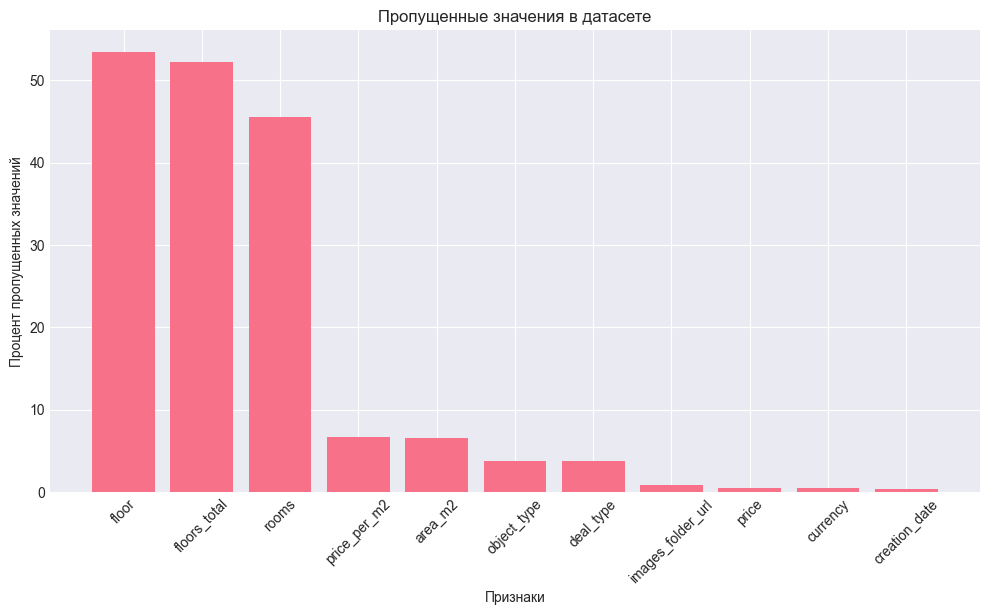

In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
missing_df = missing_df[missing_df['Количество пропусков'] > 0].sort_values('Процент пропусков', ascending=False)
print(missing_df)

plt.figure(figsize=(12, 6))
plt.bar(missing_df.index, missing_df['Процент пропусков'])
plt.xlabel('Признаки')
plt.ylabel('Процент пропущенных значений')
plt.title('Пропущенные значения в датасете')
plt.xticks(rotation=45)
plt.show()

### Анализ распределения цен *(с обработкой копии датасета по `99%` квантилю сверху)*

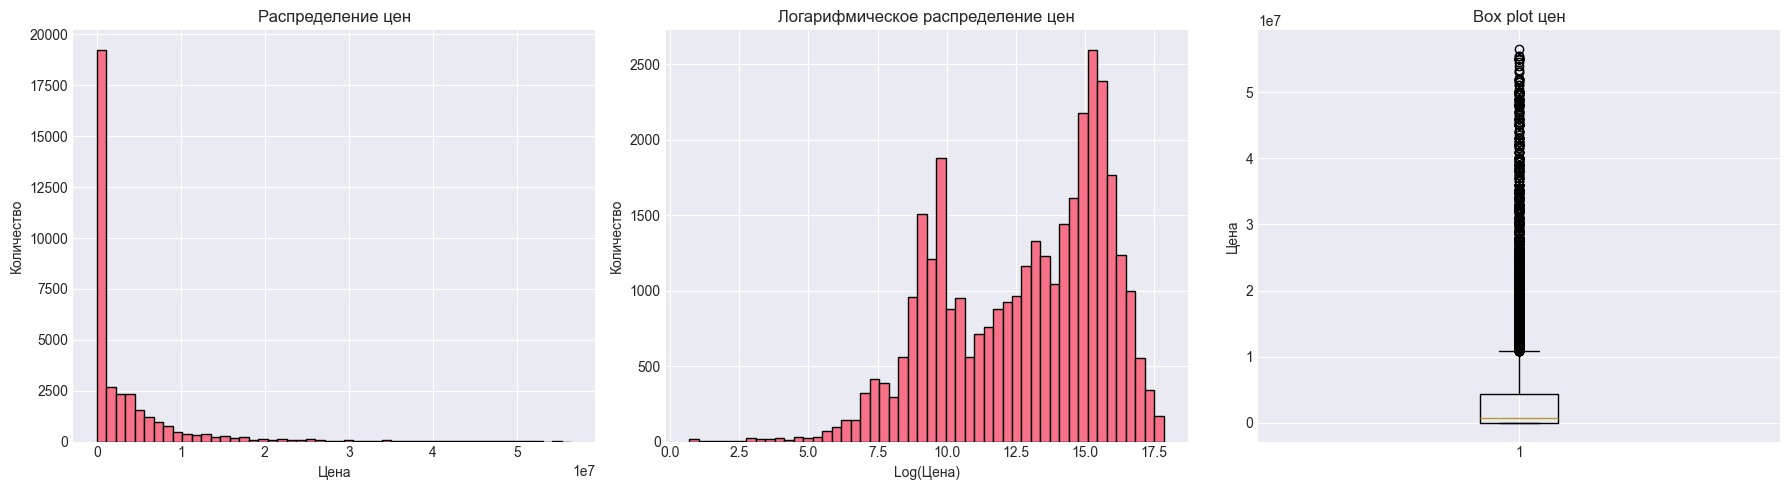

In [7]:
df_analysis = df[(df['price'] > 0) & (df['price'] < df['price'].quantile(0.99))].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_analysis['price'], bins=50, edgecolor='black')
axes[0].set_xlabel('Цена')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение цен')

df_analysis['log_price'] = np.log1p(df_analysis['price'])
axes[1].hist(df_analysis['log_price'], bins=50, edgecolor='black')
axes[1].set_xlabel('Log(Цена)')
axes[1].set_ylabel('Количество')
axes[1].set_title('Логарифмическое распределение цен')

axes[2].boxplot(df_analysis['price'])
axes[2].set_ylabel('Цена')
axes[2].set_title('Box plot цен')

plt.tight_layout()
plt.show()

### Анализ распределения категориальных признаков

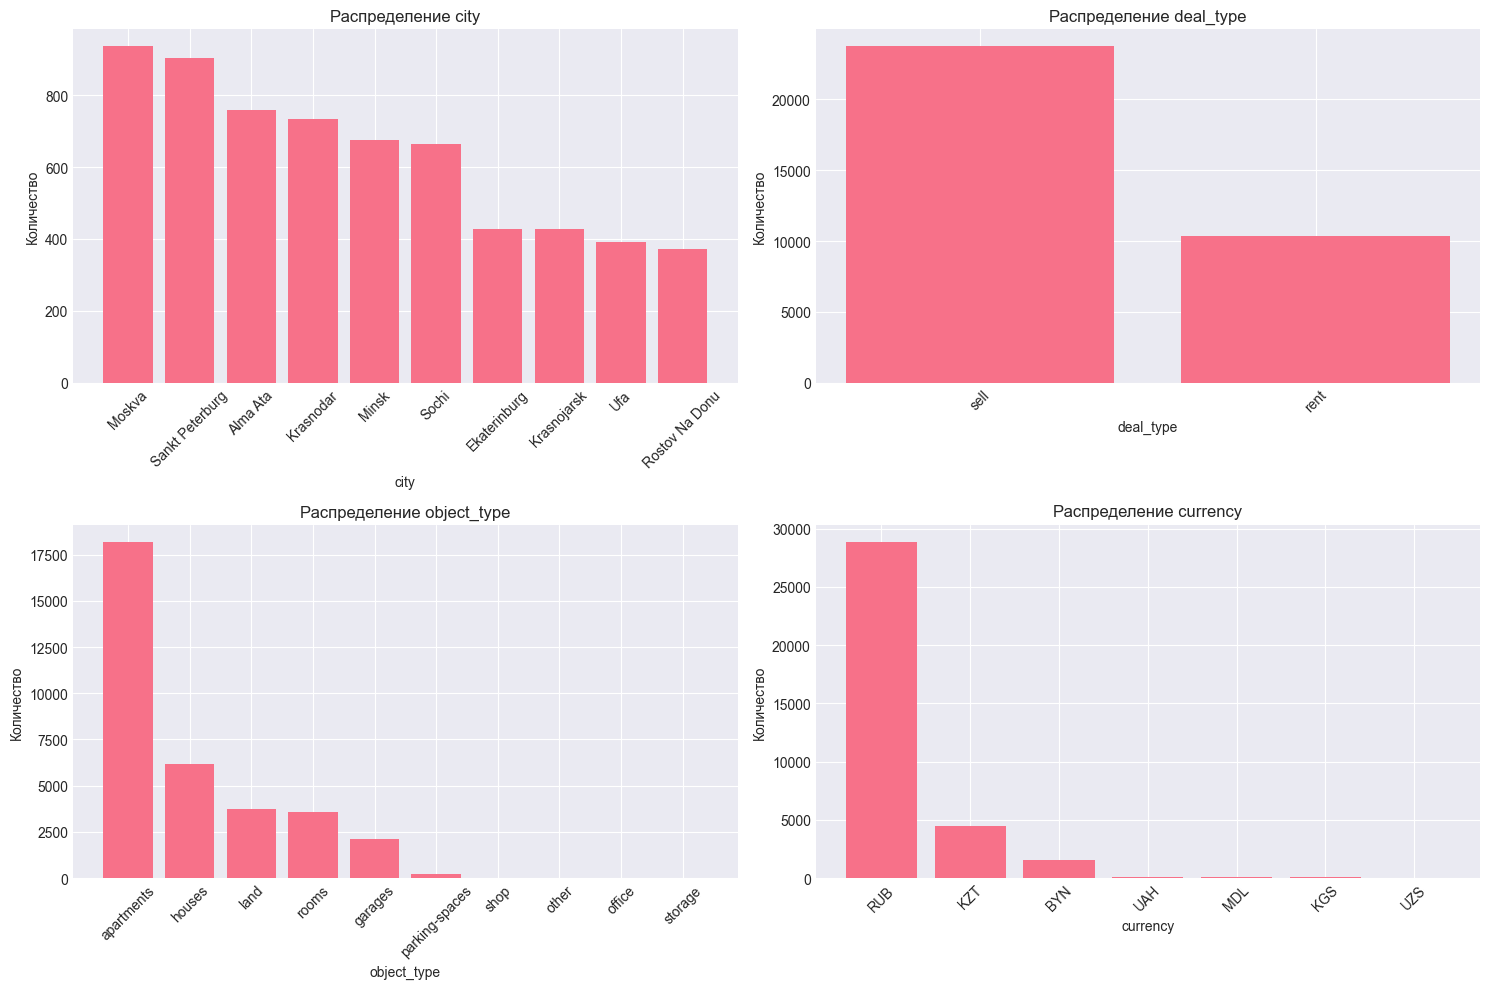

In [8]:
categorical_features = ['city', 'deal_type', 'object_type', 'currency']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    value_counts = df[feature].value_counts()
    axes[idx].bar(value_counts.index[:10], value_counts.values[:10])
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Количество')
    axes[idx].set_title(f'Распределение {feature}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Анализ зависимости цены от различных факторов и средние значения

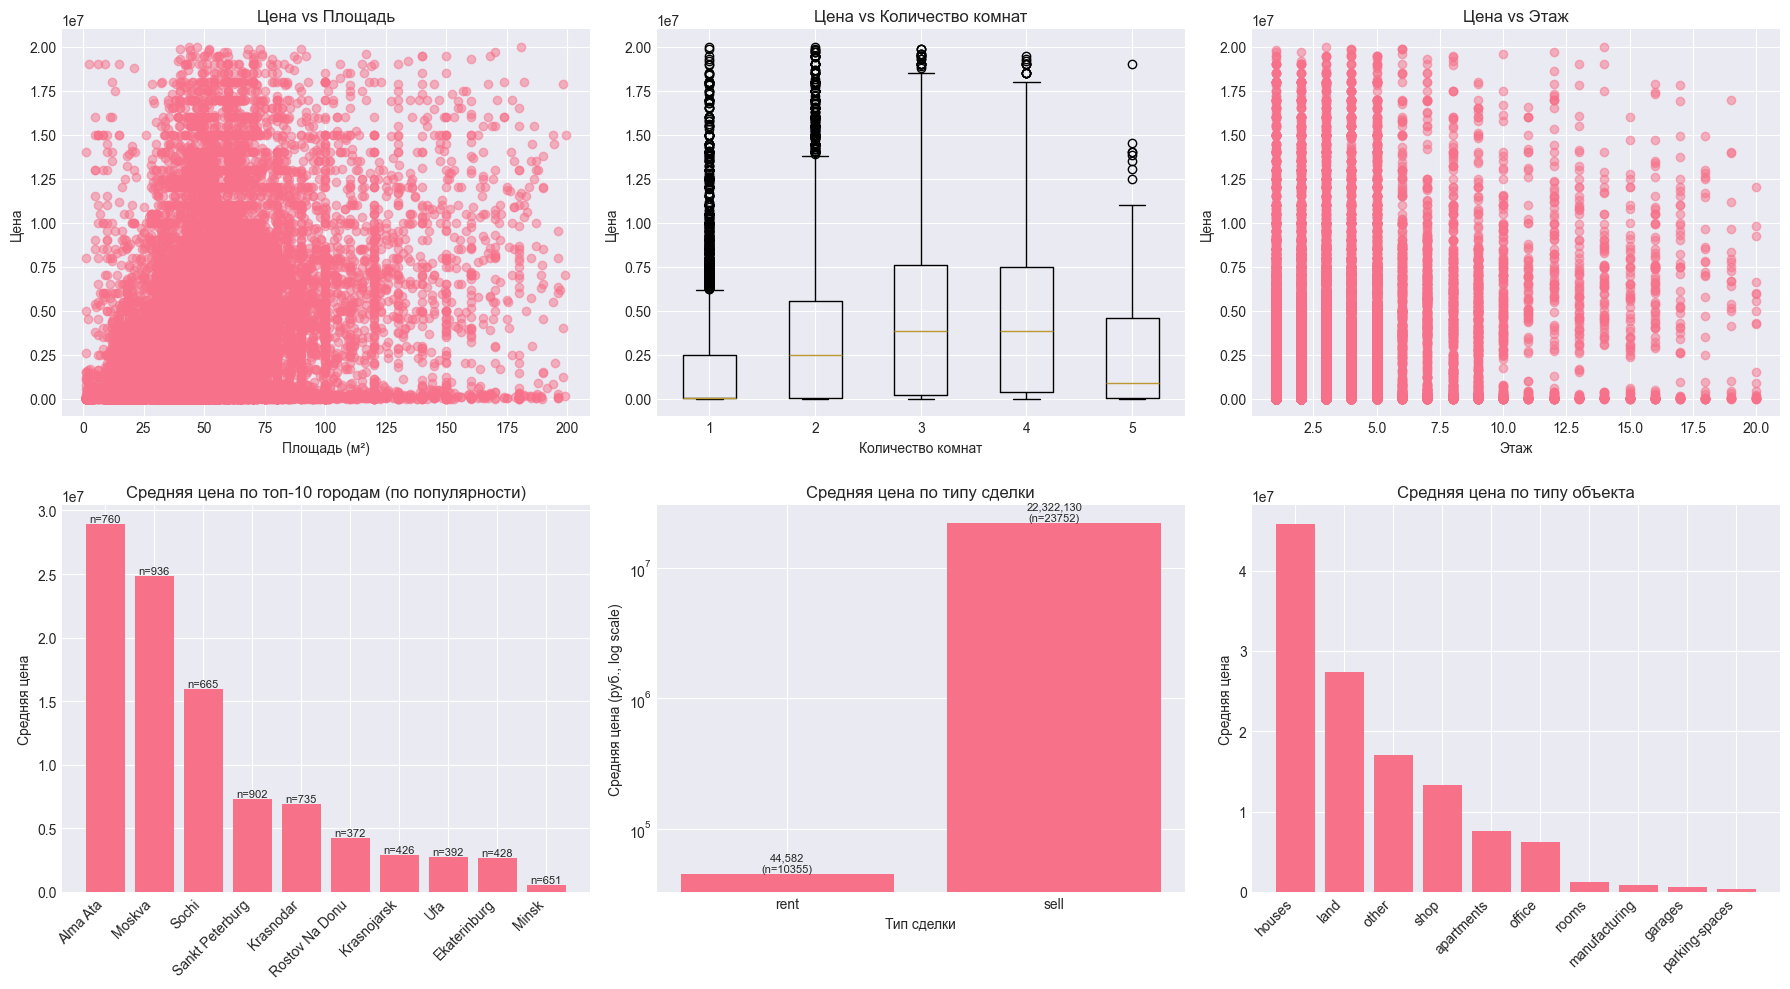

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Цена vs Площадь
df_plot = df[(df['area_m2'] > 0) & (df['area_m2'] < 200) & (df['price'] < 20000000)]
axes[0, 0].scatter(df_plot['area_m2'], df_plot['price'], alpha=0.5)
axes[0, 0].set_xlabel('Площадь (м²)')
axes[0, 0].set_ylabel('Цена')
axes[0, 0].set_title('Цена vs Площадь')

# Цена vs Кол-во комнат
df_rooms = df[df['rooms'].notna() & (df['price'] < 20000000)]
axes[0, 1].boxplot([df_rooms[df_rooms['rooms'] == i]['price'].values
                     for i in sorted(df_rooms['rooms'].unique()) if i <= 5])
axes[0, 1].set_xlabel('Количество комнат')
axes[0, 1].set_ylabel('Цена')
axes[0, 1].set_title('Цена vs Количество комнат')

# Цена vs Этаж
df_floor = df[df['floor'].notna() & (df['price'] < 20000000) & (df['floor'] <= 20)]
axes[0, 2].scatter(df_floor['floor'], df_floor['price'], alpha=0.5)
axes[0, 2].set_xlabel('Этаж')
axes[0, 2].set_ylabel('Цена')
axes[0, 2].set_title('Цена vs Этаж')

# Средняя цена по топ 10 городам (по кол-ву объявлений)
top_cities = df['city'].value_counts().head(10).index
city_data = df[df['city'].isin(top_cities)].groupby('city').agg({
    'price': ['mean', 'count']
})
city_data.columns = ['mean_price', 'count']
city_data = city_data.sort_values('mean_price', ascending=False)

axes[1, 0].bar(range(len(city_data)), city_data['mean_price'].values)
axes[1, 0].set_xticks(range(len(city_data)))
axes[1, 0].set_xticklabels(city_data.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Средняя цена')
axes[1, 0].set_title('Средняя цена по топ-10 городам (по популярности)')

for i, (city, row) in enumerate(city_data.iterrows()):
    axes[1, 0].text(i, row['mean_price'], f"n={int(row['count'])}",
                    ha='center', va='bottom', fontsize=8, rotation=0)

# Цена по типу сделки
deal_prices = df.groupby('deal_type')['price'].mean()
deal_counts = df.groupby('deal_type').size()

axes[1, 1].bar(deal_prices.index, deal_prices.values)
axes[1, 1].set_xlabel('Тип сделки')
axes[1, 1].set_ylabel('Средняя цена (руб., log scale)')
axes[1, 1].set_title('Средняя цена по типу сделки')
axes[1, 1].set_yscale('log')

for i, (deal_type, price) in enumerate(deal_prices.items()):
    count = deal_counts[deal_type]
    axes[1, 1].text(i, price, f'{price:,.0f}\n(n={count})',
                    ha='center', va='bottom', fontsize=8)

# Цена по типу объекта
object_prices = df.groupby('object_type')['price'].mean().sort_values(ascending=False)[:10]
axes[1, 2].bar(range(len(object_prices)), object_prices.values)
axes[1, 2].set_xticks(range(len(object_prices)))
axes[1, 2].set_xticklabels(object_prices.index, rotation=45, ha='right')
axes[1, 2].set_ylabel('Средняя цена')
axes[1, 2].set_title('Средняя цена по типу объекта')

plt.tight_layout()
plt.show()

### Фильтрация данных и обработка выбросов *(по 95% квантилю, обрезая по 2,5% снизу и сверху)*

In [10]:
df_processed = df.copy()

df_processed = df_processed[df_processed['price'].notna()]
df_processed = df_processed[df_processed['price'] > 0]
df_processed = df_processed[df_processed['currency'] == 'RUB']

Q1 = df_processed['price'].quantile(0.025)
Q3 = df_processed['price'].quantile(0.975)
df_processed = df_processed[(df_processed['price'] >= Q1) & (df_processed['price'] <= Q3)]

df_processed = df_processed[(df_processed['area_m2'] > 10) & (df_processed['area_m2'] < 300)]

if 'price_per_m2' in df_processed.columns:
    price_per_m2_q1 = df_processed['price_per_m2'].quantile(0.025)
    price_per_m2_q3 = df_processed['price_per_m2'].quantile(0.975)
    df_processed = df_processed[(df_processed['price_per_m2'] >= price_per_m2_q1) &
                                (df_processed['price_per_m2'] <= price_per_m2_q3)]

df_processed = df_processed[df_processed['rooms'] <= 10]
df_processed = df_processed[df_processed['floor'] <= 50]
df_processed = df_processed[df_processed['floors_total'] <= 50]

print(f"Размер датасета после фильтрации: {df_processed.shape}")
print(f"Статистика цен после фильтрации:")
print(f"Минимум: {df_processed['price'].min():,.0f}")
print(f"Максимум: {df_processed['price'].max():,.0f}")
print(f"Среднее: {df_processed['price'].mean():,.0f}")
print(f"Медиана: {df_processed['price'].median():,.0f}")

Размер датасета после фильтрации: (9422, 14)
Статистика цен после фильтрации:
Минимум: 1,500
Максимум: 19,000,000
Среднее: 3,740,332
Медиана: 3,400,000


### Заполнение пропусков медианой

In [11]:
numerical_features = ['rooms', 'floor', 'floors_total', 'area_m2', 'price_per_m2']

for feature in numerical_features:
    if feature in df_processed.columns:
        df_processed[feature] = df_processed.groupby('object_type')[feature].transform(
            lambda x: x.fillna(x.median())
        )
        df_processed[feature] = df_processed[feature].fillna(df_processed[feature].median())

print("Пропущенные значения после обработки:")
print(df_processed[numerical_features].isnull().sum())

Пропущенные значения после обработки:
rooms           0
floor           0
floors_total    0
area_m2         0
price_per_m2    0
dtype: int64


### Создание новых признаков

In [12]:
df_processed['floor_ratio'] = df_processed['floor'] / df_processed['floors_total']
df_processed['floor_ratio'] = df_processed['floor_ratio'].fillna(0.5)

df_processed['is_first_floor'] = (df_processed['floor'] == 1).astype(int)
df_processed['is_last_floor'] = (df_processed['floor'] == df_processed['floors_total']).astype(int)

df_processed['area_per_room'] = df_processed['area_m2'] / df_processed['rooms']

df_processed['area_per_room'] = df_processed['area_per_room'].replace([np.inf, -np.inf], np.nan)
df_processed['area_per_room'] = df_processed['area_per_room'].fillna(df_processed['area_per_room'].median())

df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'], format='%d.%m.%Y', errors='coerce')
df_processed['year'] = df_processed['creation_date'].dt.year
df_processed['month'] = df_processed['creation_date'].dt.month
df_processed['day_of_week'] = df_processed['creation_date'].dt.dayofweek

df_processed['urgent_tag'] = df_processed['urgent_tag'].astype(int)

### Кодирование категориальных переменных (Binary Encoding) и сравнение с One-Hot Encoding

In [13]:
categorical_columns = ['city', 'deal_type', 'object_type']

if all(col in df_processed.columns for col in categorical_columns):
    print("Уникальные значения в категориальных признаках:")
    for col in categorical_columns:
        print(f"  {col}: {df_processed[col].nunique()}")

    df_processed_original_cats = df_processed[categorical_columns].copy()

    binary_encoder = BinaryEncoder(cols=categorical_columns)
    df_encoded = binary_encoder.fit_transform(df_processed[categorical_columns])

    df_processed = df_processed.drop(columns=categorical_columns)
    df_processed = pd.concat([df_processed, df_encoded], axis=1)

    print(f"Новые столбцы после кодирования: {list(df_encoded.columns)}")
    print(f"Количество новых столбцов: {len(df_encoded.columns)}")
    print(f"\nСравнение:")
    print(f"  Binary Encoding: {len(df_encoded.columns)} столбцов")
    estimated_onehot = sum([df_processed_original_cats[col].nunique() - 1 for col in categorical_columns])
    print(f"  One-Hot Encoding создало бы: ~{estimated_onehot} столбцов")


Уникальные значения в категориальных признаках:
  city: 833
  deal_type: 2
  object_type: 2
Новые столбцы после кодирования: ['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6', 'city_7', 'city_8', 'city_9', 'deal_type_0', 'deal_type_1', 'object_type_0', 'object_type_1']
Количество новых столбцов: 14

Сравнение:
  Binary Encoding: 14 столбцов
  One-Hot Encoding создало бы: ~834 столбцов


### Подготовка данных после кодирования

In [14]:
binary_encoded_columns = [col for col in df_processed.columns if any(cat in col for cat in categorical_columns)]

feature_columns = [
    'rooms', 'floor', 'floors_total', 'area_m2',
    'floor_ratio', 'is_first_floor', 'is_last_floor', 'area_per_room',
    'year', 'month', 'day_of_week', 'urgent_tag'
] + binary_encoded_columns

df_final = df_processed[feature_columns + ['price']].dropna()

ds = df_final[feature_columns]

print(f"Финальный размер датасета: {ds.shape[0]} объектов, {ds.shape[1]} признаков")
print(f"Из них binary encoded: {len(binary_encoded_columns)} признаков")

Финальный размер датасета: 9422 объектов, 26 признаков
Из них binary encoded: 14 признаков


### Baseline решение для кластеризации *(группировка по диапазонам цены)*

Baseline кластеризация (по квантилям цены):
----------------------------------------------------------------------
Количество кластеров: 5

Распределение объектов по кластерам:
baseline_cluster
0    1886
1    1891
2    1876
3    1884
4    1885
Name: count, dtype: int64

Статистика по кластерам:
                      price                        area_m2 rooms
                       mean        min         max    mean  mean
baseline_cluster                                                
0                   71326.0     1500.0    650000.0    37.0   2.0
1                 1743894.0   660000.0   2600000.0    41.0   2.0
2                 3360128.0  2605000.0   4099000.0    47.0   2.0
3                 4990473.0  4100000.0   6000000.0    53.0   2.0
4                 8542987.0  6032000.0  19000000.0    67.0   3.0
----------------------------------------------------------------------


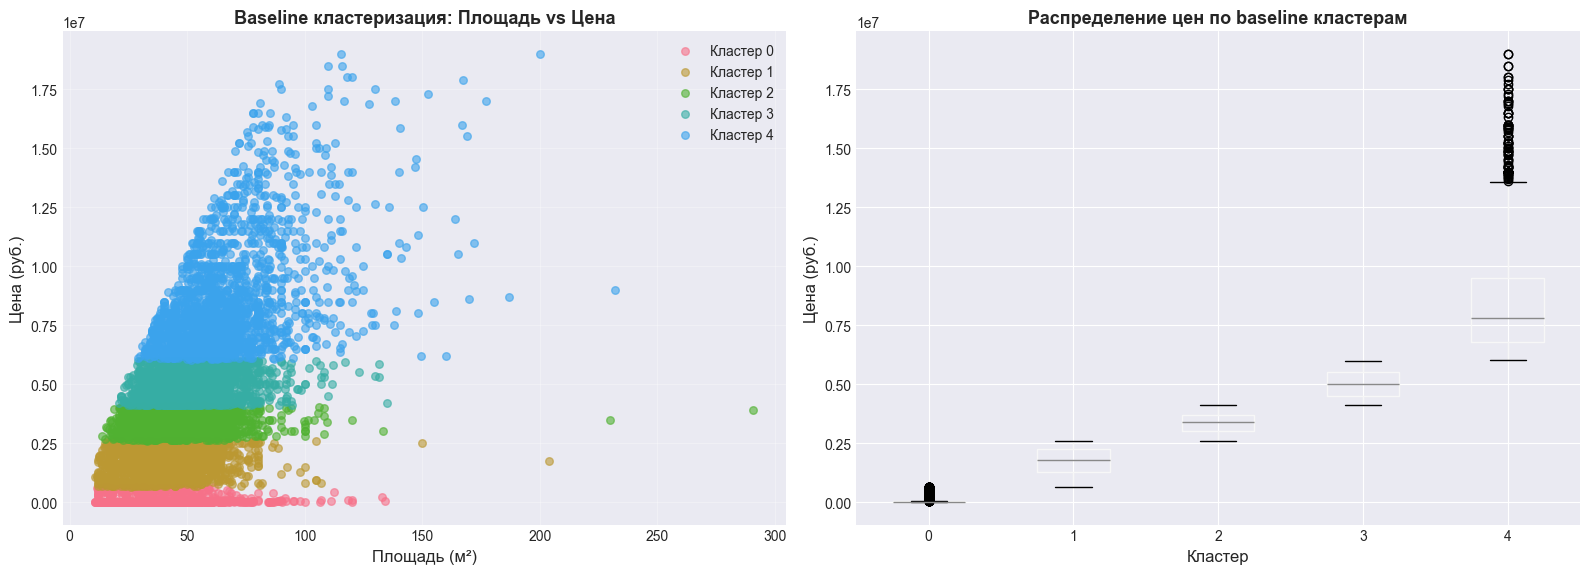

In [15]:
df_baseline = df_processed[['price', 'area_m2', 'rooms']].copy()
df_baseline = df_baseline.dropna()

df_baseline['baseline_cluster'] = pd.qcut(df_baseline['price'], q=5, labels=[0, 1, 2, 3, 4], duplicates='drop')

print("Baseline кластеризация (по квантилям цены):")
print("-"*70)
print(f"Количество кластеров: {df_baseline['baseline_cluster'].nunique()}")
print("\nРаспределение объектов по кластерам:")
print(df_baseline['baseline_cluster'].value_counts().sort_index())

print("\nСтатистика по кластерам:")
cluster_stats = df_baseline.groupby('baseline_cluster', observed=False).agg({
    'price': ['mean', 'min', 'max'],
    'area_m2': 'mean',
    'rooms': 'mean'
}).round(0)
print(cluster_stats)
print("-"*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# [Scatter plot] площадь vs цена с раскраской по кластерам
for cluster in sorted(df_baseline['baseline_cluster'].unique()):
    cluster_data = df_baseline[df_baseline['baseline_cluster'] == cluster]
    axes[0].scatter(cluster_data['area_m2'], cluster_data['price'],
                   label=f'Кластер {cluster}', alpha=0.6, s=30)

axes[0].set_xlabel('Площадь (м²)', fontsize=12)
axes[0].set_ylabel('Цена (руб.)', fontsize=12)
axes[0].set_title('Baseline кластеризация: Площадь vs Цена', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# [Box plot] цен по кластерам
df_baseline.boxplot(column='price', by='baseline_cluster', ax=axes[1])
axes[1].set_xlabel('Кластер', fontsize=12)
axes[1].set_ylabel('Цена (руб.)', fontsize=12)
axes[1].set_title('Распределение цен по baseline кластерам', fontsize=13, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()


### Подготовка данных для кластеризации и нормализация

In [16]:
X = df_final[feature_columns].values
y_price = df_final['price'].values  # (Сохраняем для анализа, но не используем при обучении)

print(f"Размер датасета для кластеризации: {X.shape}")
print(f"Количество признаков: {X.shape[1]}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nStandardScaler:")
print(f"Mean после нормализации: {X_scaled.mean(axis=0)[:5]}")
print(f"Std после нормализации: {X_scaled.std(axis=0)[:5]}")


Размер датасета для кластеризации: (9422, 26)
Количество признаков: 26

StandardScaler:
Mean после нормализации: [ 1.44793255e-16 -2.41322092e-17 -1.20661046e-17 -2.65454302e-16
  1.31973019e-17]
Std после нормализации: [1. 1. 1. 1. 1.]


### Визуализация латентного пространства с помощью PCA

PCA: объясненная дисперсия = 0.2134
  - 1-я компонента: 0.1200
  - 2-я компонента: 0.0934


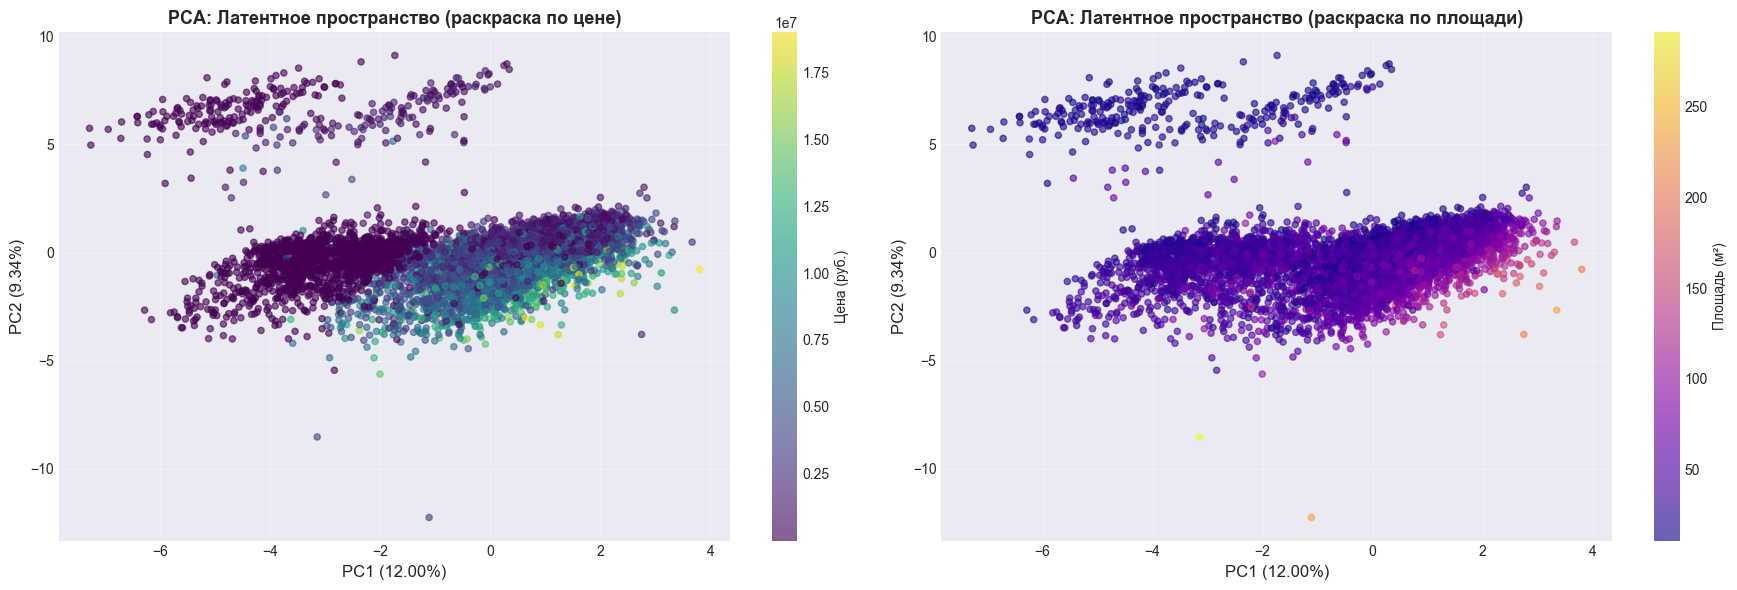

In [17]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA: объясненная дисперсия = {pca.explained_variance_ratio_.sum():.4f}")
print(f"  - 1-я компонента: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  - 2-я компонента: {pca.explained_variance_ratio_[1]:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# PCA с раскраской по цене
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_price,
                          cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0].set_title('PCA: Латентное пространство (раскраска по цене)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Цена (руб.)')
axes[0].grid(True, alpha=0.3)

# PCA с раскраской по площади
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=df_final['area_m2'].values,
                           cmap='plasma', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[1].set_title('PCA: Латентное пространство (раскраска по площади)', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Площадь (м²)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Визуализация латентного пространства с помощью UMAP

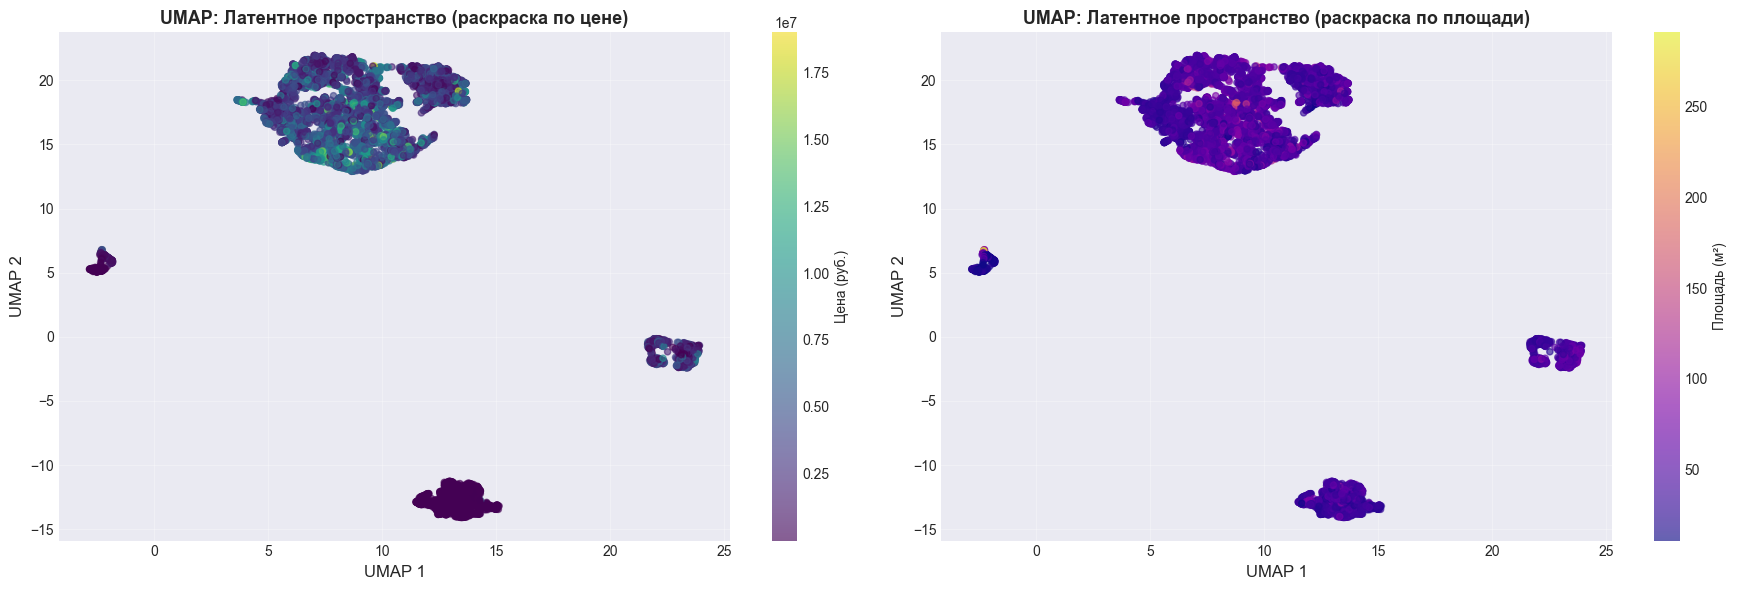

In [18]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, n_jobs=1)
X_umap = umap_reducer.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# UMAP с раскраской по цене
scatter = axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=y_price,
                          cmap='viridis', alpha=0.6, s=20)
axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].set_title('UMAP: Латентное пространство (раскраска по цене)', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Цена (руб.)')
axes[0].grid(True, alpha=0.3)

# UMAP с раскраской по площади
scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1],
                           c=df_final['area_m2'].values,
                           cmap='plasma', alpha=0.6, s=20)
axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].set_title('UMAP: Латентное пространство (раскраска по площади)', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Площадь (м²)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Подбор оптимального количества кластеров (Elbow Method + Silhouette Score)

Подбор оптимального количества кластеров (k):
----------------------------------------------------------------------
k=2: Silhouette=0.2048, Davies-Bouldin=2.3316, Calinski-Harabasz=1015
k=3: Silhouette=0.1885, Davies-Bouldin=1.7828, Calinski-Harabasz=997
k=4: Silhouette=0.1141, Davies-Bouldin=2.1719, Calinski-Harabasz=890
k=5: Silhouette=0.1038, Davies-Bouldin=2.4401, Calinski-Harabasz=819
k=6: Silhouette=0.1056, Davies-Bouldin=2.0774, Calinski-Harabasz=794
k=7: Silhouette=0.1062, Davies-Bouldin=2.1140, Calinski-Harabasz=756
k=8: Silhouette=0.1021, Davies-Bouldin=2.0937, Calinski-Harabasz=702
k=9: Silhouette=0.1131, Davies-Bouldin=1.8243, Calinski-Harabasz=706
k=10: Silhouette=0.1012, Davies-Bouldin=2.0144, Calinski-Harabasz=665
----------------------------------------------------------------------


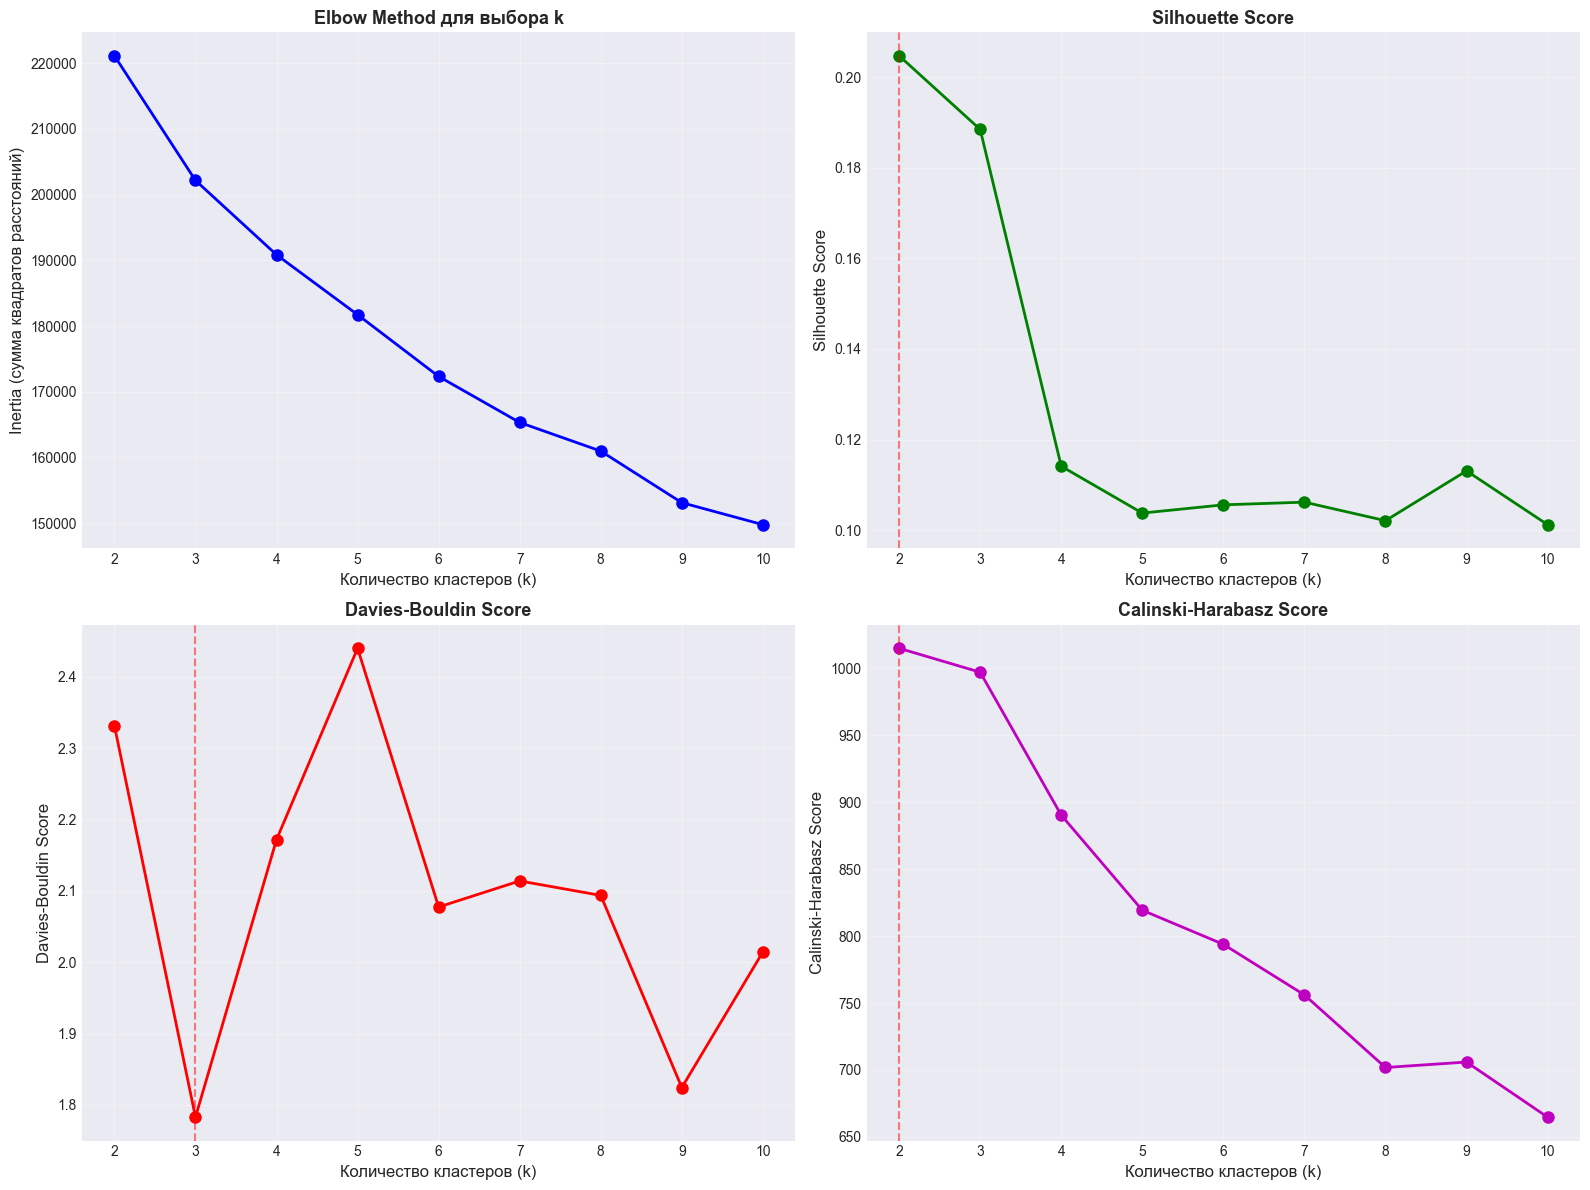


Рекомендуемое количество кластеров:
По Silhouette Score: k=2
По Davies-Bouldin: k=3
По Calinski-Harabasz: k=2

Используем k=2 (по Silhouette Score)


In [19]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Подбор оптимального количества кластеров (k):")
print("-"*70)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.4f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.4f}, "
          f"Calinski-Harabasz={calinski_harabasz_scores[-1]:.0f}")

print("-"*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (сумма квадратов расстояний)', fontsize=12)
axes[0, 0].set_title('Elbow Method для выбора k', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score (чем выше, тем лучше)
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.5)

# Davies-Bouldin Score (чем ниже, тем лучше)
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Score', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
best_k_db = k_range[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(x=best_k_db, color='red', linestyle='--', alpha=0.5)

# Calinski-Harabasz Score (чем выше, тем лучше)
axes[1, 1].plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
best_k_ch = k_range[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(x=best_k_ch, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nРекомендуемое количество кластеров:")
print(f"По Silhouette Score: k={best_k_silhouette}")
print(f"По Davies-Bouldin: k={best_k_db}")
print(f"По Calinski-Harabasz: k={best_k_ch}")

optimal_k = best_k_silhouette
print(f"\nИспользуем k={optimal_k} (по Silhouette Score)")


### Обучение K-Means из sklearn с оптимальными параметрами

In [20]:
kmeans_sklearn = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
labels_sklearn = kmeans_sklearn.fit_predict(X_scaled)

# Метрики качества
silhouette_sklearn = silhouette_score(X_scaled, labels_sklearn)
davies_bouldin_sklearn = davies_bouldin_score(X_scaled, labels_sklearn)
calinski_harabasz_sklearn = calinski_harabasz_score(X_scaled, labels_sklearn)

print(f"K-Means (sklearn) с k={optimal_k}:")
print("-"*70)
print(f"Silhouette Score: {silhouette_sklearn:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_sklearn:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_sklearn:.0f}")
print(f"Inertia: {kmeans_sklearn.inertia_:.2f}")
print("-"*70)

print("\nРаспределение объектов по кластерам:")
unique, counts = np.unique(labels_sklearn, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Кластер {cluster}: {count} объектов ({count/len(labels_sklearn)*100:.1f}%)")


K-Means (sklearn) с k=2:
----------------------------------------------------------------------
Silhouette Score: 0.2048
Davies-Bouldin Score: 2.3316
Calinski-Harabasz Score: 1015
Inertia: 221145.56
----------------------------------------------------------------------

Распределение объектов по кластерам:
  Кластер 0: 1710 объектов (18.1%)
  Кластер 1: 7712 объектов (81.9%)


### Визуализация результатов кластеризации (sklearn K-Means)


Статистика цен по кластерам:
              mean     median        std     min         max
cluster                                                     
0         137486.0    13000.0   697394.0  1500.0  12500000.0
1        4539199.0  4000000.0  2878216.0  2050.0  19000000.0


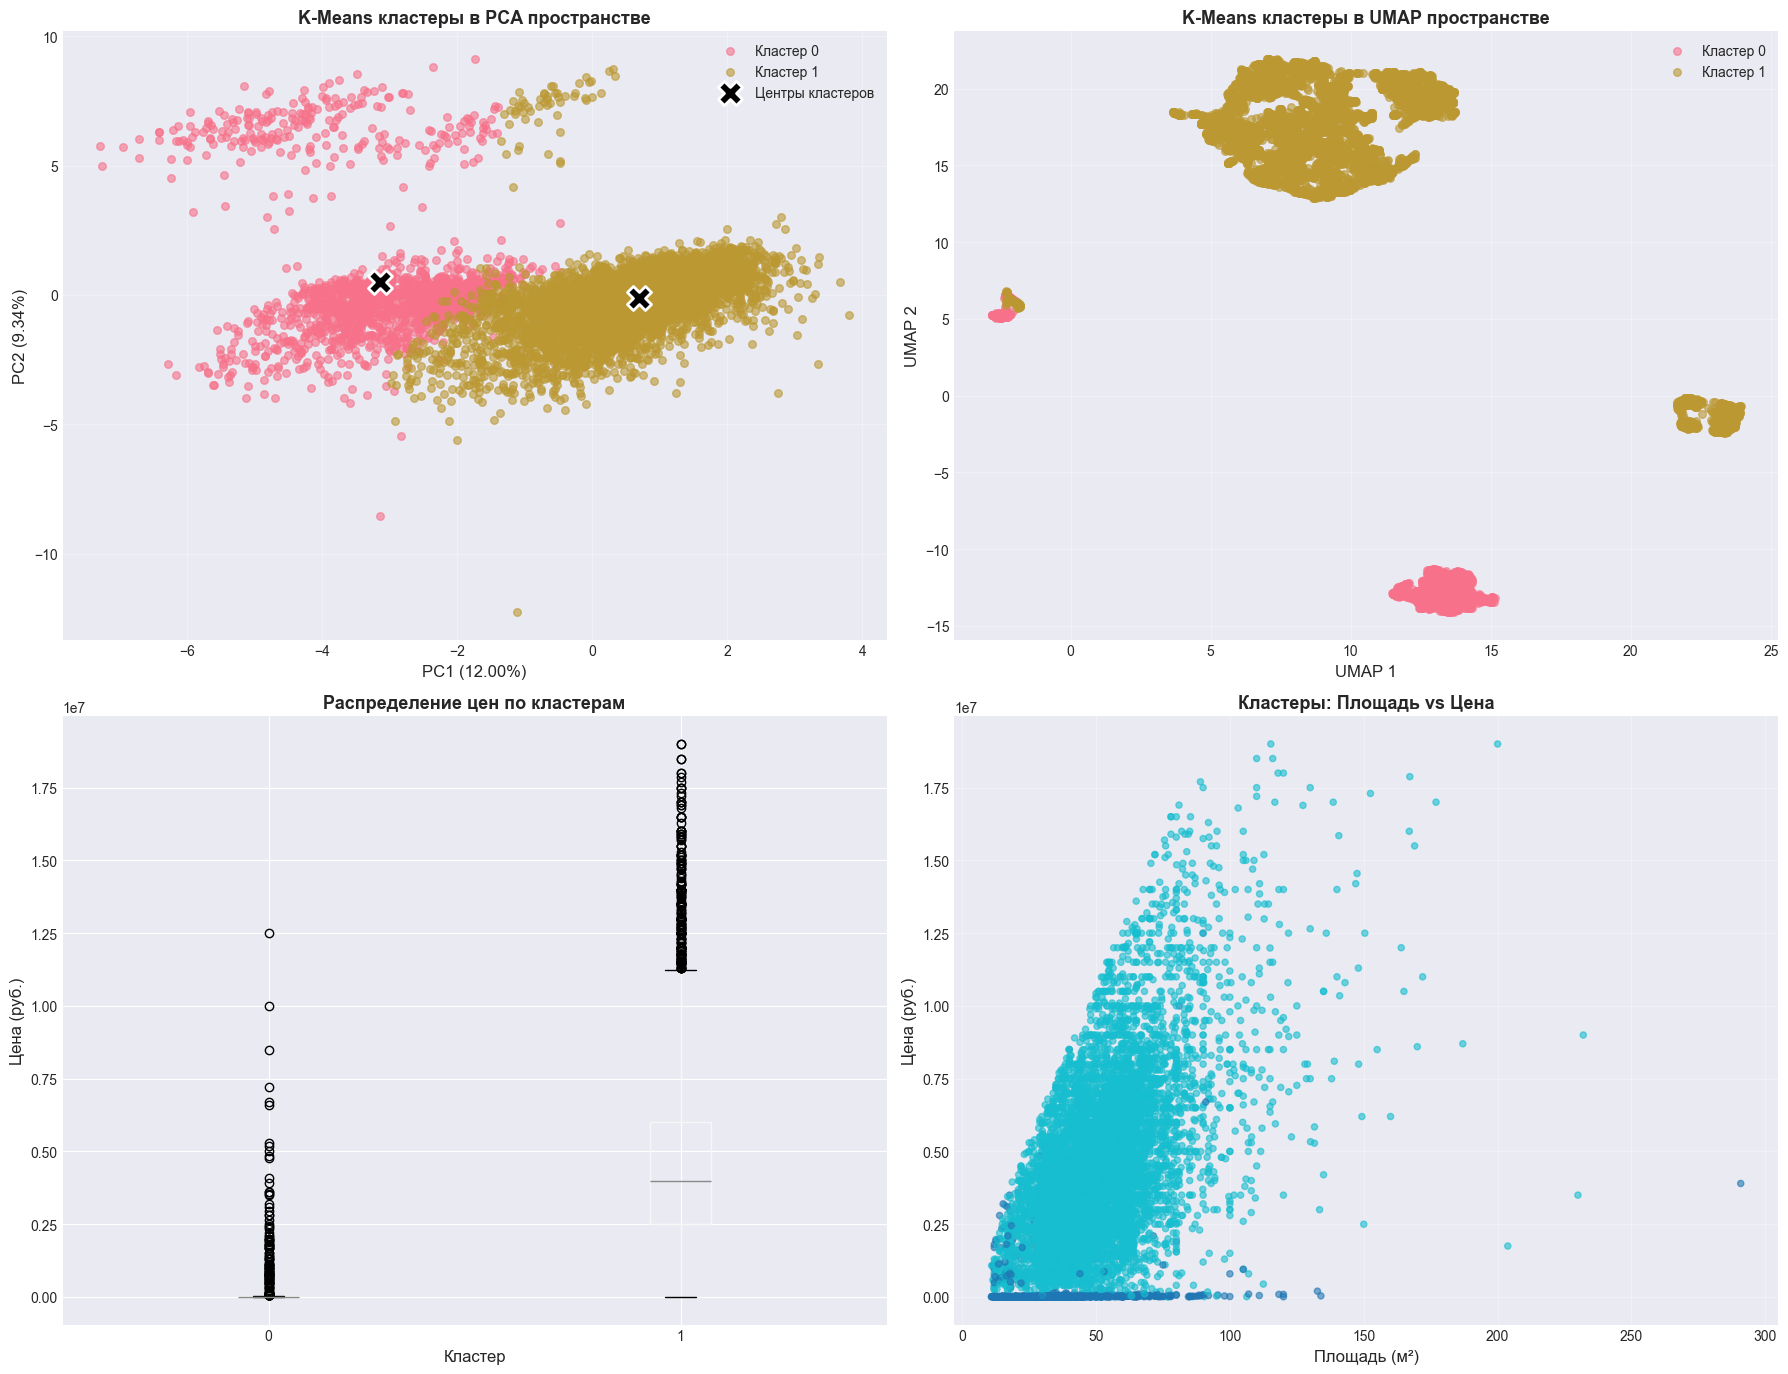

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# PCA с кластерами
for cluster in range(optimal_k):
    mask = labels_sklearn == cluster
    axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                      label=f'Кластер {cluster}', alpha=0.6, s=30)

# Центры кластеров в PCA пространстве
centers_pca = pca.transform(kmeans_sklearn.cluster_centers_)
axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1],
                  c='black', marker='X', s=300, edgecolors='white', linewidths=2,
                  label='Центры кластеров')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0, 0].set_title('K-Means кластеры в PCA пространстве', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# UMAP с кластерами
for cluster in range(optimal_k):
    mask = labels_sklearn == cluster
    axes[0, 1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                      label=f'Кластер {cluster}', alpha=0.6, s=30)

axes[0, 1].set_xlabel('UMAP 1', fontsize=12)
axes[0, 1].set_ylabel('UMAP 2', fontsize=12)
axes[0, 1].set_title('K-Means кластеры в UMAP пространстве', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Анализ кластеров по цене
df_clustered = df_final.copy()
df_clustered['cluster'] = labels_sklearn

cluster_price_stats = df_clustered.groupby('cluster')['price'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nСтатистика цен по кластерам:")
print(cluster_price_stats.round(0))

df_clustered.boxplot(column='price', by='cluster', ax=axes[1, 0])
axes[1, 0].set_xlabel('Кластер', fontsize=12)
axes[1, 0].set_ylabel('Цена (руб.)', fontsize=12)
axes[1, 0].set_title('Распределение цен по кластерам', fontsize=13, fontweight='bold')
plt.suptitle('')

# Анализ кластеров по площади
axes[1, 1].scatter(df_clustered['area_m2'], df_clustered['price'],
                  c=df_clustered['cluster'], cmap='tab10', alpha=0.6, s=20)
axes[1, 1].set_xlabel('Площадь (м²)', fontsize=12)
axes[1, 1].set_ylabel('Цена (руб.)', fontsize=12)
axes[1, 1].set_title('Кластеры: Площадь vs Цена', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Подбор гиперпараметров для K-Means (GridSearch по n_clusters и max_iter)

In [22]:
param_grid_kmeans = {
    'n_clusters': [3, 4, 5, 6, 7],
    'max_iter': [100, 200, 300, 500]
}

best_score = -1
best_params_kmeans = None
best_labels_kmeans = None
best_model_kmeans = None

results_kmeans = []

print("GridSearch для K-Means:")
print("-"*70)

for n_clusters in param_grid_kmeans['n_clusters']:
    for max_iter in param_grid_kmeans['max_iter']:
        kmeans_temp = KMeans(n_clusters=n_clusters, max_iter=max_iter,
                            random_state=42, n_init=10)
        labels_temp = kmeans_temp.fit_predict(X_scaled)

        silhouette = silhouette_score(X_scaled, labels_temp)
        davies_bouldin = davies_bouldin_score(X_scaled, labels_temp)
        calinski_harabasz = calinski_harabasz_score(X_scaled, labels_temp)

        results_kmeans.append({
            'n_clusters': n_clusters,
            'max_iter': max_iter,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz,
            'inertia': kmeans_temp.inertia_
        })

        if silhouette > best_score:
            best_score = silhouette
            best_params_kmeans = {'n_clusters': n_clusters, 'max_iter': max_iter}
            best_labels_kmeans = labels_temp
            best_model_kmeans = kmeans_temp

results_kmeans_df = pd.DataFrame(results_kmeans)

print("Топ-5 результатов по Silhouette Score:")
print(results_kmeans_df.sort_values('silhouette', ascending=False).head().to_string(index=False))
print("-"*70)

print(f"Лучшие параметры:")
print(f"  n_clusters: {best_params_kmeans['n_clusters']}")
print(f"  max_iter: {best_params_kmeans['max_iter']}")
print(f"  Silhouette Score: {best_score:.4f}")
print("-"*70)


GridSearch для K-Means:
----------------------------------------------------------------------
Топ-5 результатов по Silhouette Score:
 n_clusters  max_iter  silhouette  davies_bouldin  calinski_harabasz       inertia
          3       100    0.188503        1.782820         997.032320 202171.077757
          3       200    0.188503        1.782820         997.032320 202171.077757
          3       300    0.188503        1.782820         997.032320 202171.077757
          3       500    0.188503        1.782820         997.032320 202171.077757
          4       100    0.114094        2.171938         890.293985 190848.608198
----------------------------------------------------------------------
Лучшие параметры:
  n_clusters: 3
  max_iter: 100
  Silhouette Score: 0.1885
----------------------------------------------------------------------


### Графики качества по итерациям GridSearch

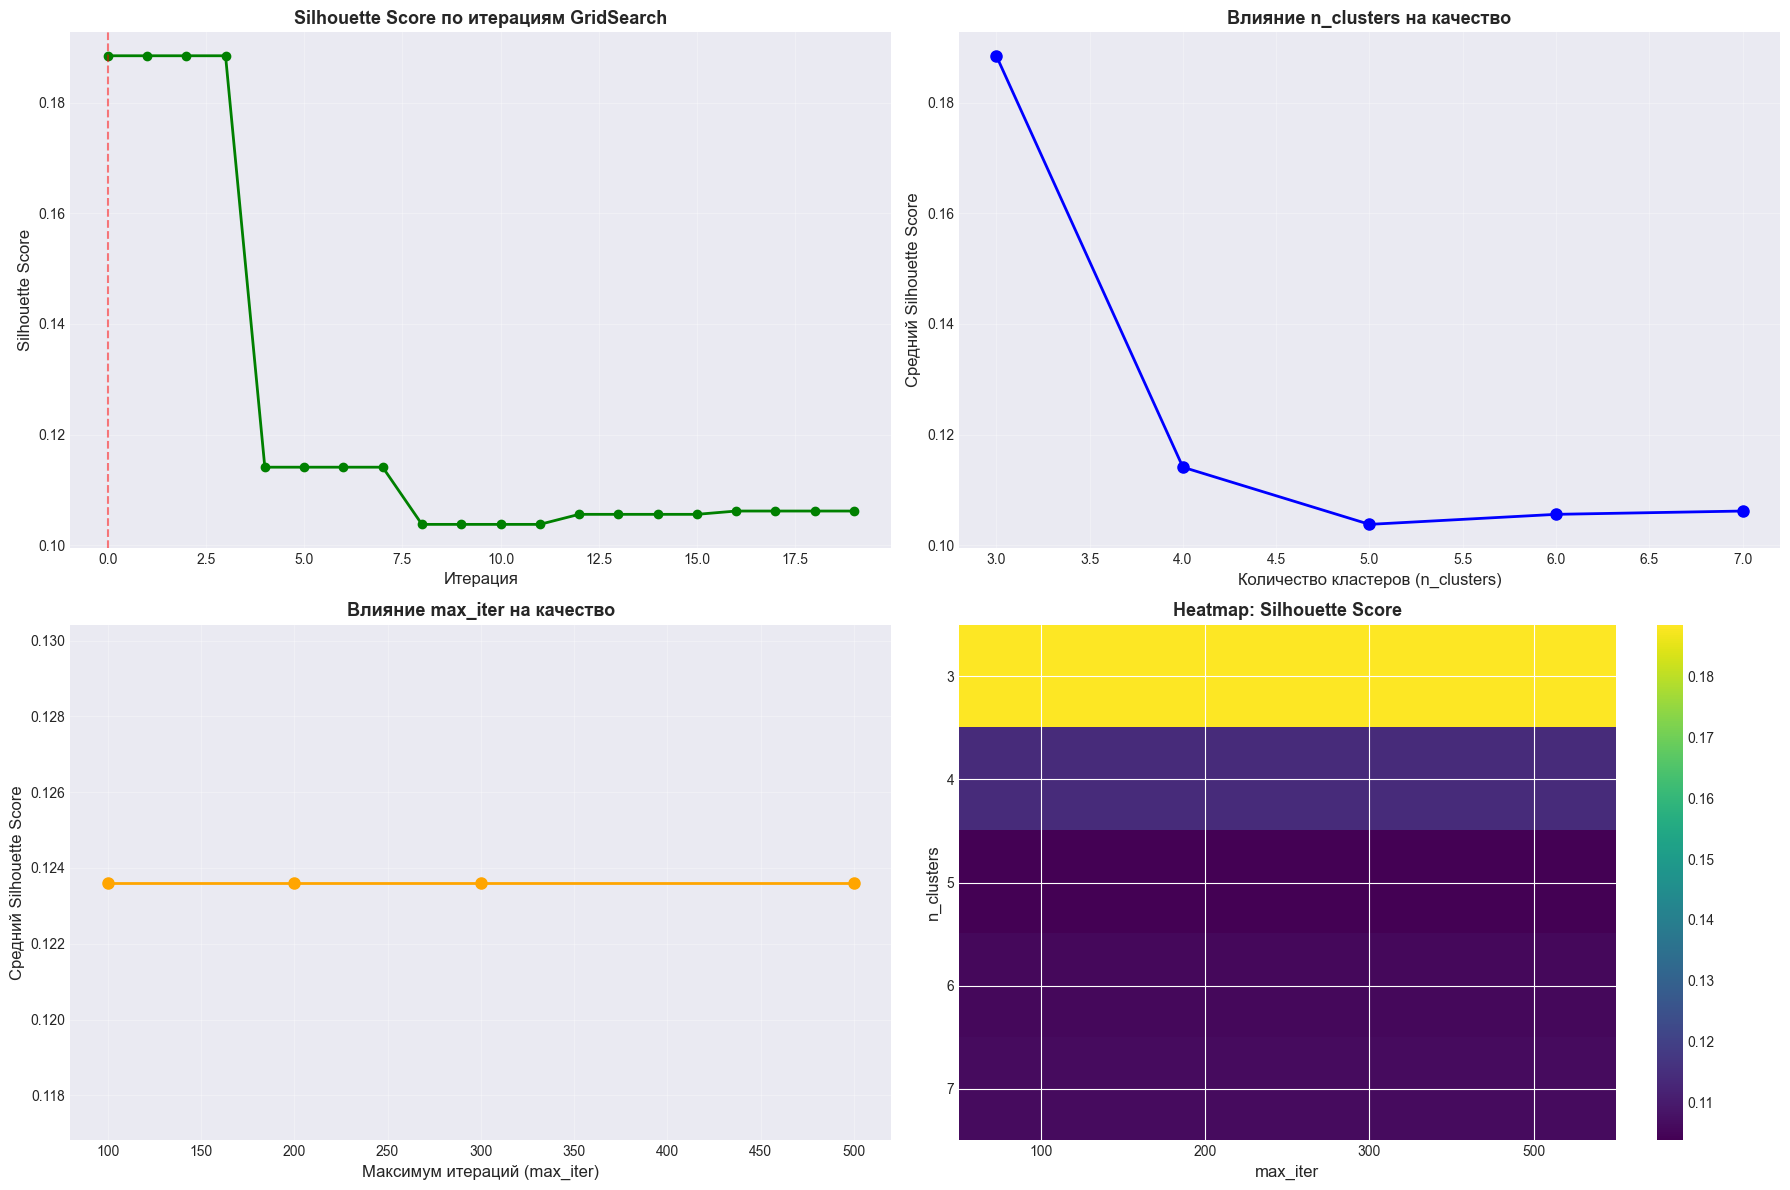

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Silhouette Score по итерациям
axes[0, 0].plot(range(len(results_kmeans)), results_kmeans_df['silhouette'], 'o-',
               linewidth=2, markersize=6, color='green')
axes[0, 0].set_xlabel('Итерация', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].set_title('Silhouette Score по итерациям GridSearch', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
best_iter = results_kmeans_df['silhouette'].idxmax()
axes[0, 0].axvline(x=best_iter, color='red', linestyle='--', alpha=0.5)

# Зависимость от n_clusters
silhouette_by_k = results_kmeans_df.groupby('n_clusters')['silhouette'].mean()
axes[0, 1].plot(silhouette_by_k.index, silhouette_by_k.values, 'o-',
               linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('Количество кластеров (n_clusters)', fontsize=12)
axes[0, 1].set_ylabel('Средний Silhouette Score', fontsize=12)
axes[0, 1].set_title('Влияние n_clusters на качество', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Зависимость от max_iter
silhouette_by_iter = results_kmeans_df.groupby('max_iter')['silhouette'].mean()
axes[1, 0].plot(silhouette_by_iter.index, silhouette_by_iter.values, 'o-',
               linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Максимум итераций (max_iter)', fontsize=12)
axes[1, 0].set_ylabel('Средний Silhouette Score', fontsize=12)
axes[1, 0].set_title('Влияние max_iter на качество', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# [Heatmap] n_clusters vs max_iter
pivot_table = results_kmeans_df.pivot_table(values='silhouette',
                                            index='n_clusters',
                                            columns='max_iter')
im = axes[1, 1].imshow(pivot_table.values, cmap='viridis', aspect='auto')
axes[1, 1].set_xticks(range(len(pivot_table.columns)))
axes[1, 1].set_xticklabels(pivot_table.columns)
axes[1, 1].set_yticks(range(len(pivot_table.index)))
axes[1, 1].set_yticklabels(pivot_table.index)
axes[1, 1].set_xlabel('max_iter', fontsize=12)
axes[1, 1].set_ylabel('n_clusters', fontsize=12)
axes[1, 1].set_title('Heatmap: Silhouette Score', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


### Реализация собственного K-Means

In [24]:
class CustomKMeans:
    """
    Гиперпараметры:
    - n_clusters: количество кластеров
    - max_iter: максимальное количество итераций
    - tolerance: порог сходимости (если центроиды изменились меньше, чем tolerance, останавливаемся)
    - random_state: seed для воспроизводимости
    """

    def __init__(self, n_clusters_amount=3, max_iters=300, tolerance=1e-4, random_state=42):
        self.n_clusters = n_clusters_amount
        self.max_iter = max_iters
        self.tolerance = tolerance
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0

    def _initialize_centers(self, X):
        """Инициализация центроидов случайным выбором из данных"""
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_indices]

    def _compute_distances(self, X, centers):
        """Вычисление евклидовых расстояний от точек до центроидов"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, center in enumerate(centers):
            distances[:, i] = np.linalg.norm(X - center, axis=1)
        return distances

    def _assign_clusters(self, distances):
        """Назначение каждой точки ближайшему кластеру"""
        return np.argmin(distances, axis=1)

    def _update_centers(self, X, labels):
        """Обновление центроидов как средних значений точек в каждом кластере"""
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = cluster_points.mean(axis=0)
            else:
                new_centers[i] = self.cluster_centers_[i]
        return new_centers

    def _compute_inertia(self, X, labels, centers):
        """Вычисление inertia"""
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - centers[i]) ** 2)
        return inertia

    def fit(self, X):
        """Обучение модели"""
        if isinstance(X, pd.DataFrame):
            X = X.values

        self.cluster_centers_ = self._initialize_centers(X)

        for iteration in range(self.max_iter):
            # Назначение точек кластерам
            distances = self._compute_distances(X, self.cluster_centers_)
            labels = self._assign_clusters(distances)

            # Обновление центроидов
            new_centers = self._update_centers(X, labels)

            # Проверка сходимости
            center_shift = np.linalg.norm(new_centers - self.cluster_centers_)
            self.cluster_centers_ = new_centers
            self.n_iter_ = iteration + 1

            if center_shift < self.tolerance:
                break

        distances = self._compute_distances(X, self.cluster_centers_)
        self.labels_ = self._assign_clusters(distances)
        self.inertia_ = self._compute_inertia(X, self.labels_, self.cluster_centers_)

        return self

    def predict(self, X):
        """Предсказание кластеров для новых данных"""
        if isinstance(X, pd.DataFrame):
            X = X.values

        distances = self._compute_distances(X, self.cluster_centers_)
        return self._assign_clusters(distances)

    def fit_predict(self, X):
        """Обучение и предсказание"""
        self.fit(X)
        return self.labels_

print("Гиперпараметры:")
print(" - n_clusters: количество кластеров")
print(" - max_iter: максимальное количество итераций")
print(" - tolerance: порог сходимости")
print(" - random_state: seed для воспроизводимости")


Гиперпараметры:
 - n_clusters: количество кластеров
 - max_iter: максимальное количество итераций
 - tolerance: порог сходимости
 - random_state: seed для воспроизводимости


### Обучение собственного K-Means с оптимальными параметрами

In [25]:
custom_kmeans = CustomKMeans(
    n_clusters_amount=best_params_kmeans['n_clusters'],
    max_iters=best_params_kmeans['max_iter'],
    tolerance=1e-4,
    random_state=42
)

labels_custom = custom_kmeans.fit_predict(X_scaled)

# Метрики качества
silhouette_custom = silhouette_score(X_scaled, labels_custom)
davies_bouldin_custom = davies_bouldin_score(X_scaled, labels_custom)
calinski_harabasz_custom = calinski_harabasz_score(X_scaled, labels_custom)

print(f"Custom K-Means с n_clusters={best_params_kmeans['n_clusters']}, max_iter={best_params_kmeans['max_iter']}:")
print("-"*70)
print(f"Количество итераций до сходимости: {custom_kmeans.n_iter_}")
print(f"Silhouette Score: {silhouette_custom:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_custom:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_custom:.0f}")
print(f"Inertia: {custom_kmeans.inertia_:.2f}")
print("-"*70)

print("\nРаспределение объектов по кластерам:")
unique_custom, counts_custom = np.unique(labels_custom, return_counts=True)
for cluster, count in zip(unique_custom, counts_custom):
    print(f"  Кластер {cluster}: {count} объектов ({count/len(labels_custom)*100:.1f}%)")


Custom K-Means с n_clusters=3, max_iter=100:
----------------------------------------------------------------------
Количество итераций до сходимости: 26
Silhouette Score: 0.0836
Davies-Bouldin Score: 2.8982
Calinski-Harabasz Score: 787
Inertia: 209895.19
----------------------------------------------------------------------

Распределение объектов по кластерам:
  Кластер 0: 2331 объектов (24.7%)
  Кластер 1: 1663 объектов (17.7%)
  Кластер 2: 5428 объектов (57.6%)


### Подбор гиперпараметров для собственного K-Means

In [26]:
param_grid_custom_kmeans = {
    'n_clusters': [3, 4, 5, 6, 7],
    'max_iter': [100, 200, 300, 500],
    'tolerance': [1e-4, 1e-3, 1e-2]
}

best_score_custom = -1
best_params_custom = None
best_labels_custom = None
best_model_custom = None

results_custom_kmeans = []

print("GridSearch для Custom K-Means:")
print("-"*70)

iteration = 0
for n_clusters in param_grid_custom_kmeans['n_clusters']:
    for max_iter in param_grid_custom_kmeans['max_iter']:
        for tolerance in param_grid_custom_kmeans['tolerance']:
            iteration += 1

            custom_temp = CustomKMeans(n_clusters_amount=n_clusters, max_iters=max_iter,
                                       tolerance=tolerance, random_state=42)
            labels_temp = custom_temp.fit_predict(X_scaled)

            silhouette = silhouette_score(X_scaled, labels_temp)
            davies_bouldin = davies_bouldin_score(X_scaled, labels_temp)
            calinski_harabasz = calinski_harabasz_score(X_scaled, labels_temp)

            results_custom_kmeans.append({
                'iteration': iteration,
                'n_clusters': n_clusters,
                'max_iter': max_iter,
                'tolerance': tolerance,
                'n_iter': custom_temp.n_iter_,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz,
                'inertia': custom_temp.inertia_
            })

            if silhouette > best_score_custom:
                best_score_custom = silhouette
                best_params_custom = {
                    'n_clusters': n_clusters,
                    'max_iter': max_iter,
                    'tolerance': tolerance
                }
                best_labels_custom = labels_temp
                best_model_custom = custom_temp

results_custom_kmeans_df = pd.DataFrame(results_custom_kmeans)

print("Топ-10 результатов по Silhouette Score:")
print(results_custom_kmeans_df.sort_values('silhouette', ascending=False).head(10).to_string(index=False))
print("-"*70)

print(f"\nЛучшие параметры Custom K-Means:")
print(f" n_clusters: {best_params_custom['n_clusters']}")
print(f" max_iter: {best_params_custom['max_iter']}")
print(f" tolerance: {best_params_custom['tolerance']}")
print(f" Silhouette Score: {best_score_custom:.4f}")
print(f" Количество итераций до сходимости: {best_model_custom.n_iter_}")
print("-"*70)


GridSearch для Custom K-Means:
----------------------------------------------------------------------
Топ-10 результатов по Silhouette Score:
 iteration  n_clusters  max_iter  tolerance  n_iter  silhouette  davies_bouldin  calinski_harabasz       inertia
        25           5       100     0.0001      29    0.084528        2.695056         625.741461 193532.544809
        26           5       100     0.0010      29    0.084528        2.695056         625.741461 193532.544809
        28           5       200     0.0001      29    0.084528        2.695056         625.741461 193532.544809
        29           5       200     0.0010      29    0.084528        2.695056         625.741461 193532.544809
        34           5       500     0.0001      29    0.084528        2.695056         625.741461 193532.544809
        32           5       300     0.0010      29    0.084528        2.695056         625.741461 193532.544809
        31           5       300     0.0001      29    0.084528    

### Визуализация обучения Custom K-Means по итерациям

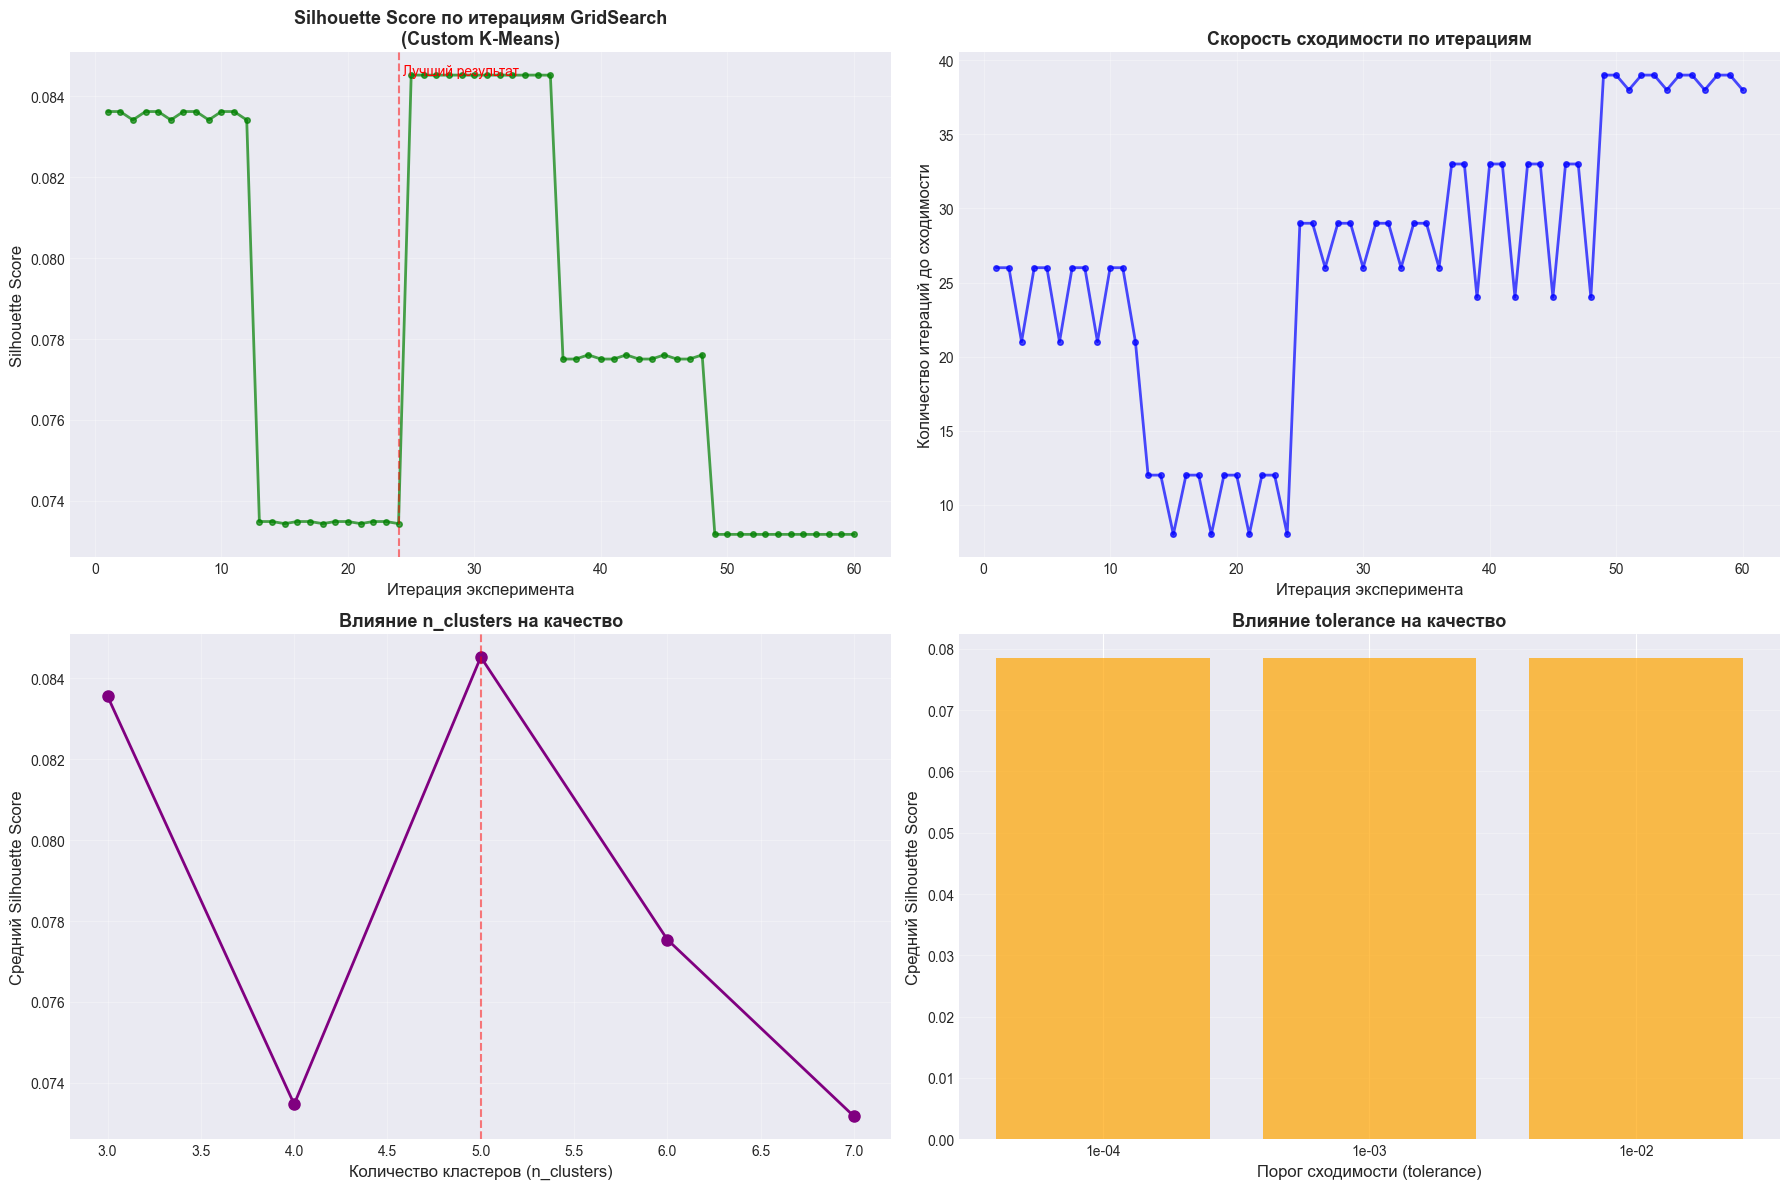

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Silhouette Score по итерациям
axes[0, 0].plot(results_custom_kmeans_df['iteration'],
               results_custom_kmeans_df['silhouette'],
               'o-', linewidth=2, markersize=4, color='green', alpha=0.7)
axes[0, 0].set_xlabel('Итерация эксперимента', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].set_title('Silhouette Score по итерациям GridSearch\n(Custom K-Means)',
                     fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
best_iter_custom = results_custom_kmeans_df['silhouette'].idxmax()
axes[0, 0].axvline(x=best_iter_custom, color='red', linestyle='--', alpha=0.5)
axes[0, 0].text(best_iter_custom, results_custom_kmeans_df['silhouette'].max(),
               ' Лучший результат', color='red', fontsize=10)

# Количество итераций до сходимости
axes[0, 1].plot(results_custom_kmeans_df['iteration'],
               results_custom_kmeans_df['n_iter'],
               'o-', linewidth=2, markersize=4, color='blue', alpha=0.7)
axes[0, 1].set_xlabel('Итерация эксперимента', fontsize=12)
axes[0, 1].set_ylabel('Количество итераций до сходимости', fontsize=12)
axes[0, 1].set_title('Скорость сходимости по итерациям', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Влияние n_clusters
silhouette_by_k_custom = results_custom_kmeans_df.groupby('n_clusters')['silhouette'].mean()
axes[1, 0].plot(silhouette_by_k_custom.index, silhouette_by_k_custom.values,
               'o-', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_xlabel('Количество кластеров (n_clusters)', fontsize=12)
axes[1, 0].set_ylabel('Средний Silhouette Score', fontsize=12)
axes[1, 0].set_title('Влияние n_clusters на качество', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=best_params_custom['n_clusters'], color='red', linestyle='--', alpha=0.5)

# Влияние tolerance
silhouette_by_tol = results_custom_kmeans_df.groupby('tolerance')['silhouette'].mean()
axes[1, 1].bar(range(len(silhouette_by_tol)), silhouette_by_tol.values,
              color='orange', alpha=0.7)
axes[1, 1].set_xticks(range(len(silhouette_by_tol)))
axes[1, 1].set_xticklabels([f'{tolerance:.0e}' for tolerance in silhouette_by_tol.index])
axes[1, 1].set_xlabel('Порог сходимости (tolerance)', fontsize=12)
axes[1, 1].set_ylabel('Средний Silhouette Score', fontsize=12)
axes[1, 1].set_title('Влияние tolerance на качество', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


### Визуализация результатов Custom K-Means


Статистика цен по кластерам (Custom K-Means):
              mean     median        std     min         max
cluster                                                     
0        4857340.0  4399000.0  2766800.0  2050.0  19000000.0
1         101000.0    12000.0   491659.0  1500.0   8500000.0
2        3551622.0  3000000.0  2387951.0  4700.0  17500000.0
3        3021647.0  2550000.0  2184600.0  8000.0  14500000.0
4        6204498.0  6000000.0  3533901.0  1500.0  19000000.0


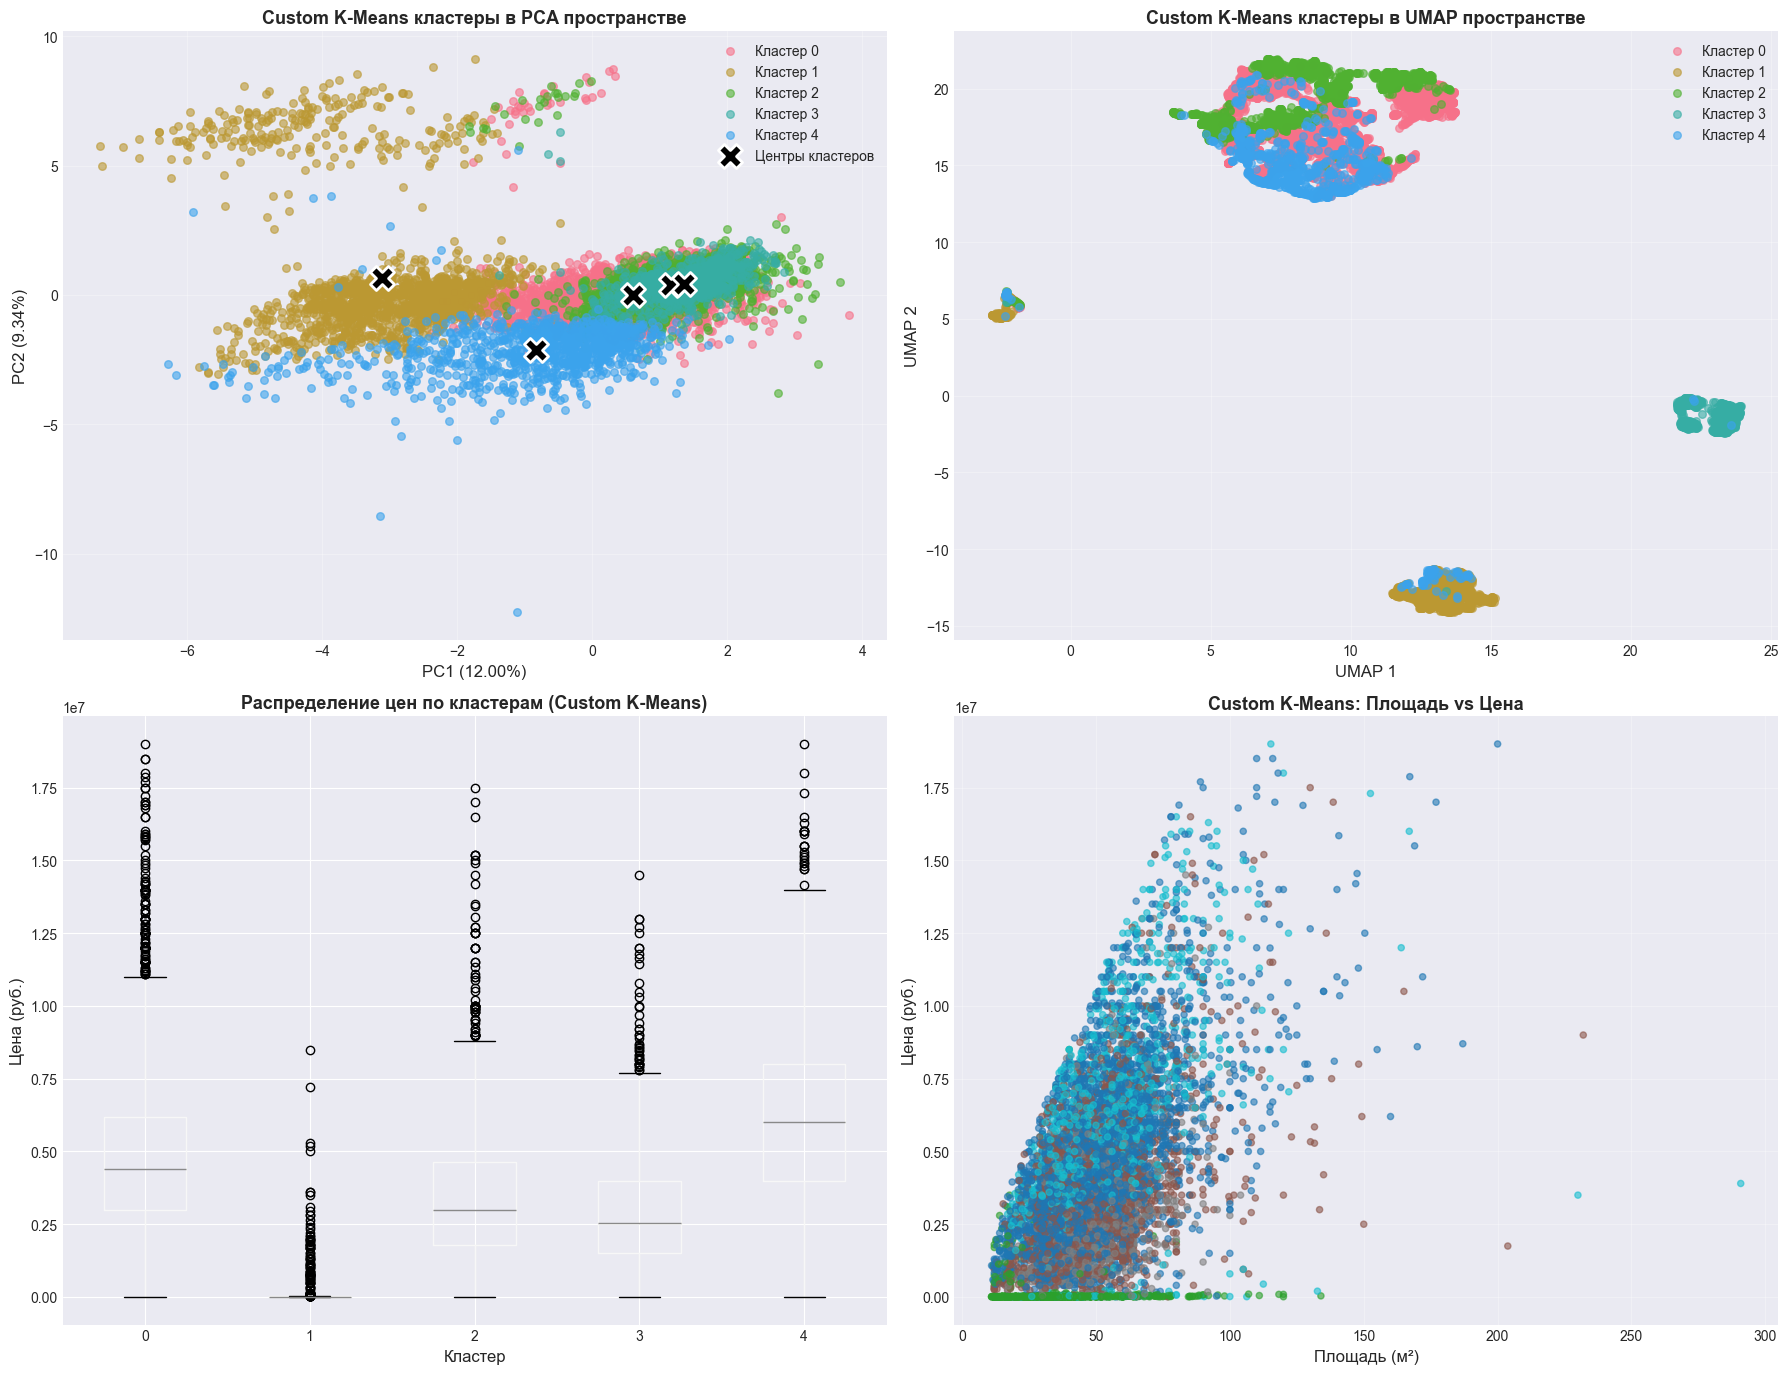

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# PCA с кластерами
for cluster in range(best_params_custom['n_clusters']):
    mask = best_labels_custom == cluster
    axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                      label=f'Кластер {cluster}', alpha=0.6, s=30)

# Центры кластеров в PCA пространстве
centers_pca_custom = pca.transform(best_model_custom.cluster_centers_)
axes[0, 0].scatter(centers_pca_custom[:, 0], centers_pca_custom[:, 1],
                  c='black', marker='X', s=300, edgecolors='white', linewidths=2,
                  label='Центры кластеров')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
axes[0, 0].set_title('Custom K-Means кластеры в PCA пространстве', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# UMAP с кластерами
for cluster in range(best_params_custom['n_clusters']):
    mask = best_labels_custom == cluster
    axes[0, 1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                      label=f'Кластер {cluster}', alpha=0.6, s=30)

axes[0, 1].set_xlabel('UMAP 1', fontsize=12)
axes[0, 1].set_ylabel('UMAP 2', fontsize=12)
axes[0, 1].set_title('Custom K-Means кластеры в UMAP пространстве', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Анализ кластеров по цене
df_clustered_custom = df_final.copy()
df_clustered_custom['cluster'] = best_labels_custom

cluster_price_stats_custom = df_clustered_custom.groupby('cluster')['price'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nСтатистика цен по кластерам (Custom K-Means):")
print(cluster_price_stats_custom.round(0))

df_clustered_custom.boxplot(column='price', by='cluster', ax=axes[1, 0])
axes[1, 0].set_xlabel('Кластер', fontsize=12)
axes[1, 0].set_ylabel('Цена (руб.)', fontsize=12)
axes[1, 0].set_title('Распределение цен по кластерам (Custom K-Means)', fontsize=13, fontweight='bold')
plt.suptitle('')

# Анализ кластеров по площади
axes[1, 1].scatter(df_clustered_custom['area_m2'], df_clustered_custom['price'],
                  c=df_clustered_custom['cluster'], cmap='tab10', alpha=0.6, s=20)
axes[1, 1].set_xlabel('Площадь (м²)', fontsize=12)
axes[1, 1].set_ylabel('Цена (руб.)', fontsize=12)
axes[1, 1].set_title('Custom K-Means: Площадь vs Цена', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Сравнение моделей: sklearn K-Means vs Custom K-Means

Сравнение моделей:
----------------------------------------------------------------------
         Модель  n_clusters  max_iter  Silhouette Score  Davies-Bouldin  Calinski-Harabasz       Inertia
sklearn K-Means           3       100          0.188503        1.782820         997.032320 202171.077757
 Custom K-Means           5       100          0.084528        2.695056         625.741461 193532.544809
----------------------------------------------------------------------

Анализ различий:
  Разница в Silhouette Score: 0.103976 (55.16%)
  Разница в Inertia: 8638.53 (4.27%)


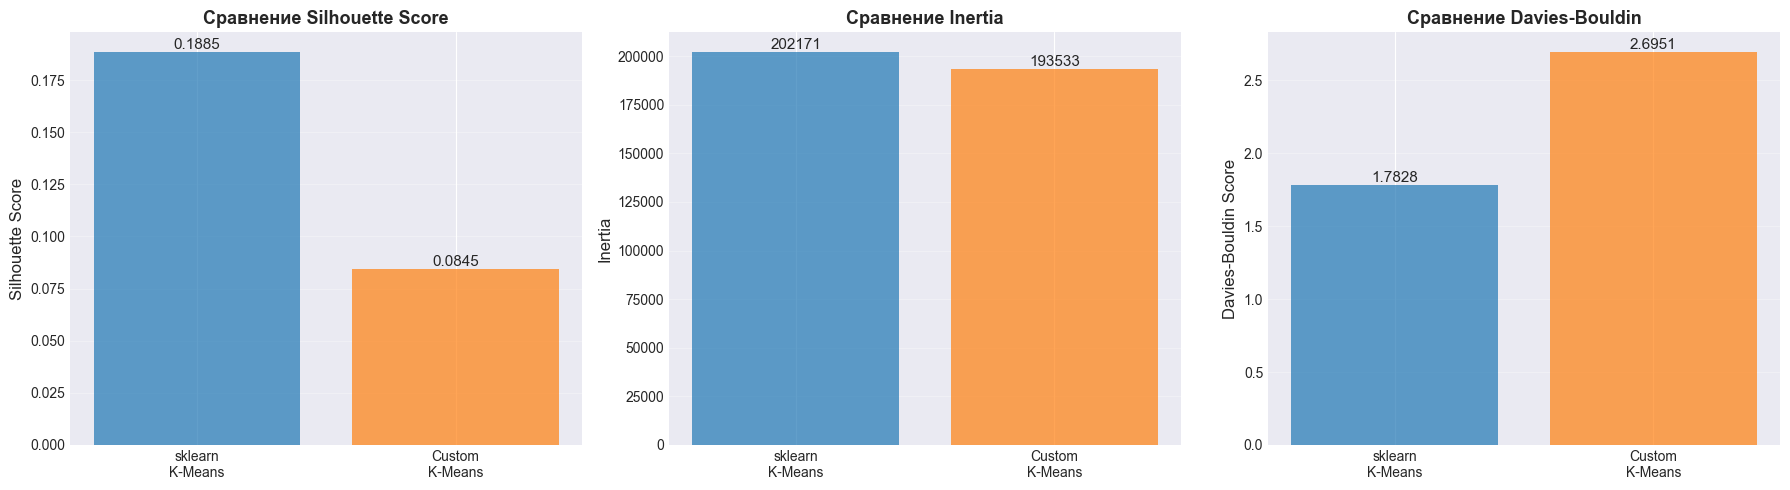

In [29]:
comparison_df = pd.DataFrame({
    'Модель': ['sklearn K-Means', 'Custom K-Means'],
    'n_clusters': [best_params_kmeans['n_clusters'], best_params_custom['n_clusters']],
    'max_iter': [best_params_kmeans['max_iter'], best_params_custom['max_iter']],
    'Silhouette Score': [best_score, best_score_custom],
    'Davies-Bouldin': [
        davies_bouldin_score(X_scaled, best_labels_kmeans),
        davies_bouldin_score(X_scaled, best_labels_custom)
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(X_scaled, best_labels_kmeans),
        calinski_harabasz_score(X_scaled, best_labels_custom)
    ],
    'Inertia': [best_model_kmeans.inertia_, best_model_custom.inertia_]
})

print("Сравнение моделей:")
print("-"*70)
print(comparison_df.to_string(index=False))
print("-"*70)

# Разница в метриках
silhouette_diff = abs(best_score - best_score_custom)
inertia_diff = abs(best_model_kmeans.inertia_ - best_model_custom.inertia_)

print(f"\nАнализ различий:")
print(f"  Разница в Silhouette Score: {silhouette_diff:.6f} ({silhouette_diff/best_score*100:.2f}%)")
print(f"  Разница в Inertia: {inertia_diff:.2f} ({inertia_diff/best_model_kmeans.inertia_*100:.2f}%)")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Сравнение Silhouette Score
models = ['sklearn\nK-Means', 'Custom\nK-Means']
silhouette_values = [best_score, best_score_custom]
axes[0].bar(models, silhouette_values, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Сравнение Silhouette Score', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(silhouette_values):
    axes[0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=11)

# Сравнение Inertia
inertia_values = [best_model_kmeans.inertia_, best_model_custom.inertia_]
axes[1].bar(models, inertia_values, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
axes[1].set_ylabel('Inertia', fontsize=12)
axes[1].set_title('Сравнение Inertia', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(inertia_values):
    axes[1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=11)

# Сравнение Davies-Bouldin Score (чем меньше, тем лучше)
db_values = comparison_df['Davies-Bouldin'].values
axes[2].bar(models, db_values, color=['#1f77b4', '#ff7f0e'], alpha=0.7)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Сравнение Davies-Bouldin', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(db_values):
    axes[2].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()
